In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.naive_bayes import GaussianNB, CategoricalNB, BernoulliNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from scipy.signal import savgol_filter
import matplotlib.ticker as plticker


In [58]:
import tensorflow as tf

tf.config.set_visible_devices([], 'GPU')

# if tf.test.gpu_device_name(): # this lies and tells you about all devices
if tf.config.experimental.list_logical_devices('GPU'):
    print('GPU found')
else:
    print("No GPU found")

No GPU found


In [59]:
# writer = pd.ExcelWriter("Ket qua phan loai khong dao ham.xlsx", engine='xlsxwriter')

In [60]:
data = pd.read_excel("../../data/Dataset_HPLC.xlsx", sheet_name="Vungtrong (140)")
data.head(5)

,No.,Name,Group,%CM,%CA,%CAL,600,602,604,606,...,3982,3984,3986,3988,3990,3992,3994,3996,3998,4000
0,1,21.1.8.YB-13,1,2.57,0.09,9.83,0.222,0.223,0.221,0.217,...,-0.006,-0.006,-0.006,-0.006,-0.006,-0.006,-0.006,-0.006,-0.006,-0.006
1,2,21.1.8.YB-24,1,0.69,0.04,3.75,0.263,0.261,0.257,0.257,...,-0.007,-0.007,-0.007,-0.007,-0.006,-0.007,-0.007,-0.007,-0.007,-0.007
2,3,21.1.8.YB-38,1,0.43,0.05,5.53,0.252,0.253,0.253,0.252,...,-0.006,-0.007,-0.007,-0.007,-0.006,-0.007,-0.007,-0.007,-0.007,-0.007
3,4,21.1.8.YB-40,1,2.04,0.06,5.21,0.259,0.258,0.259,0.259,...,-0.008,-0.009,-0.009,-0.009,-0.008,-0.008,-0.008,-0.009,-0.009,-0.009
4,5,21.1.8.YB-41,1,0.13,0.09,4.60,0.206,0.203,0.200,0.198,...,0.000,-0.001,0.000,0.001,0.001,0.000,0.000,-0.001,-0.001,-0.001


In [61]:
y = data["Group"]
# le = LabelEncoder()
# y = le.fit_transform(y)
X = data.iloc[:, 6:]
X.columns = X.columns.astype(str)
cols = X.columns
# print(np.unique(y))
# print(le.inverse_transform(np.unique(y)))

In [62]:
X = savgol_filter(X, window_length=25, polyorder=5, deriv=0)

In [63]:
X = pd.DataFrame(X, columns=cols)

/tmp/ipykernel_13141/495723894.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')


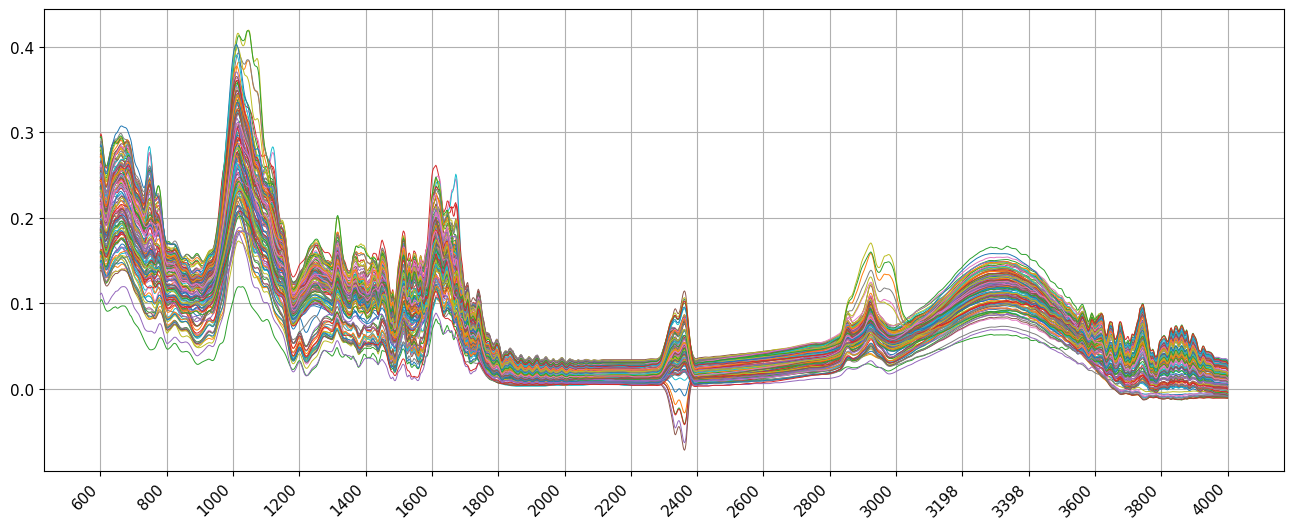

In [64]:
fig, ax = plt.subplots(figsize = (16, 6))
ax.plot(X.T, linewidth = 0.7)
loc = plticker.MultipleLocator(base=100.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
# ax.set_xticks(rotation = 90)
plt.grid()
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
plt.show()

In [65]:
X = np.array(X)  # In case it's not already a NumPy array
y = np.array(y)

n_classes = len(np.unique(y))
# Define how many samples per class you want in the validation set
n_test_samples_per_class = int(len(X) * 0.25 / n_classes)  # Modify this based on your need

# Get unique class labels
classes = np.unique(y)
# Lists to hold train and test data
X_train_list, X_test_list = [], []
y_train_list, y_test_list = [], []

# For each class, split data to have equal test size
for cls in classes:
    # Get indices for this class
    class_indices = np.where(y == cls)[0]
    
    # Split the data for this class
    X_class, X_class_test, y_class, y_class_test = train_test_split(
        X[class_indices], y[class_indices], test_size=n_test_samples_per_class, random_state=42
    )
    
    # Append the splits to the train/test lists
    X_train_list.append(X_class)
    X_test_list.append(X_class_test)
    y_train_list.append(y_class)
    y_test_list.append(y_class_test)

# Combine back into arrays
X_train = np.vstack(X_train_list)  # Combine all classes' training data
X_test = np.vstack(X_test_list)      # Combine all classes' test data
y_train = np.hstack(y_train_list)  # Combine all classes' training labels
y_test = np.hstack(y_test_list)      # Combine all classes' test labels

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_test.shape, y_test.shape)

Training set shape: (107, 1701) (107,)
Validation set shape: (32, 1701) (32,)


In [66]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error
from typing import Union, List, Dict

import numpy as np
from joblib import Parallel, delayed
class SPA():
    def __init__(self,
                 n_features_to_select: int = None,
                 n_cv_folds: int = 5,
                 pls: PLSRegression = None,
                 n_jobs: int = -1):
        self.n_features_to_select = n_features_to_select
        self.pls = SVC(kernel = 'linear')
        self.n_cv_folds = n_cv_folds
        self.n_jobs = n_jobs

    def fit_spa(self, X, y, seed):
        wavelength_map = np.arange(X.shape[1])
        selected_wave_length = [seed]
        selected_vector = X[:, seed:seed+1]
        remain_wavelength = np.delete(wavelength_map, seed)
        remain_vectors = np.delete(X, seed, 1)

        for i in range(self.n_features_to_select - 1):
            selected_vector = selected_vector / np.linalg.norm(selected_vector, ord = 2)
            orthogonal_vectors = remain_vectors - selected_vector @ np.transpose(np.transpose(remain_vectors) @ selected_vector)
            orthogonal_norms = np.linalg.norm(orthogonal_vectors, ord = 2, axis=0)
            max_length_vector_idx = np.argmax(orthogonal_norms)

            selected_wave_length.append(remain_wavelength[max_length_vector_idx])
            wavelength_map = np.delete(wavelength_map, max_length_vector_idx, )

            selected_vector = orthogonal_vectors[:, max_length_vector_idx:max_length_vector_idx+1]
            remain_wavelength = np.delete(remain_wavelength, max_length_vector_idx)
            remain_vectors = np.delete(remain_vectors, max_length_vector_idx, 1)

        loss = 1 - np.mean(cross_val_score(self.pls, X[:, selected_wave_length], y, cv = self.n_cv_folds))
        # mse = cro(y_pred, y)
        return loss, selected_wave_length

    def fit(self, X, y):
        candidates = Parallel(n_jobs=self.n_jobs)(delayed(self.fit_spa)(X, y, seed) for seed in range(X.shape[1]))
        print(candidates)
        loss, otp_wavelength = min(candidates, key=lambda x: x[1])

        return loss, otp_wavelength


In [67]:
spa_lda = SPA(100)
mse, otp_wavelength = spa_lda.fit(X_train, y_train)
otp_wavelength = sorted(otp_wavelength)
X_train = X_train[:, otp_wavelength]
X_test = X_test[:, otp_wavelength]

[(0.3822510822510823, [0, 201, 208, 200, 207, 202, 209, 199, 206, 198, 210, 203, 205, 197, 211, 204, 212, 196, 213, 881, 214, 457, 215, 458, 216, 456, 217, 459, 218, 455, 219, 1572, 220, 880, 221, 882, 222, 1573, 223, 1571, 224, 879, 225, 1570, 226, 883, 227, 1574, 228, 878, 229, 1569, 195, 460, 230, 473, 194, 454, 231, 474, 232, 475, 193, 472, 233, 476, 234, 466, 235, 453, 32, 467, 31, 465, 33, 471, 30, 452, 236, 461, 192, 506, 237, 505, 34, 504, 29, 507, 35, 503, 28, 502, 36, 501, 37, 508, 238, 500, 38, 509]), (0.3822510822510823, [1, 201, 208, 200, 207, 202, 209, 199, 206, 198, 210, 203, 205, 197, 211, 204, 212, 196, 213, 881, 214, 457, 215, 458, 216, 456, 217, 459, 218, 455, 219, 1572, 220, 880, 221, 882, 222, 1573, 223, 1571, 224, 879, 225, 1570, 226, 883, 227, 1574, 228, 878, 229, 1569, 195, 460, 230, 473, 194, 454, 231, 474, 232, 475, 193, 472, 233, 476, 234, 466, 235, 453, 32, 467, 31, 465, 33, 471, 30, 452, 236, 461, 192, 506, 237, 505, 34, 504, 29, 507, 35, 503, 28, 502, 36, 

In [68]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.fit_transform(X_test)

In [69]:
onehot = OneHotEncoder(sparse_output=False)
y_train = onehot.fit_transform(y_train.reshape(-1,1))
y_test = onehot.fit_transform(y_test.reshape(-1,1))

In [70]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [80]:
import tensorflow as tf
import random

tf.random.set_seed(1)
random.seed(1)
np.random.seed(1)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(X_train.shape[1], 1)))
# model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Conv1D(filters=12, kernel_size=3))
# model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
# model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=5))
# model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
# model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3))
# model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
# model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=3))
# model.add(tf.keras.layers.Conv1D(filters=24, kernel_size=3))
# model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(24, activation='relu'))
# model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer="Adam", loss = 'CategoricalCrossentropy', metrics = ['accuracy'])
history=model.fit(X_train, y_train, batch_size=8, epochs=40, validation_data=(X_test, y_test))

Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4321 - loss: 1.2464 - val_accuracy: 0.3750 - val_loss: 1.2247
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5442 - loss: 1.0670 - val_accuracy: 0.4375 - val_loss: 1.1416
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5821 - loss: 0.9655 - val_accuracy: 0.4375 - val_loss: 1.0590
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6072 - loss: 0.9068 - val_accuracy: 0.4688 - val_loss: 1.0030
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6414 - loss: 0.8567 - val_accuracy: 0.5000 - val_loss: 0.9194
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6487 - loss: 0.8181 - val_accuracy: 0.5625 - val_loss: 0.8529
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7135 - loss: 0.7868 - val_accuracy: 0.5938 - val_loss: 0.7915
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7412 - loss: 0.7550 - val_accuracy: 0.5938 - val_los

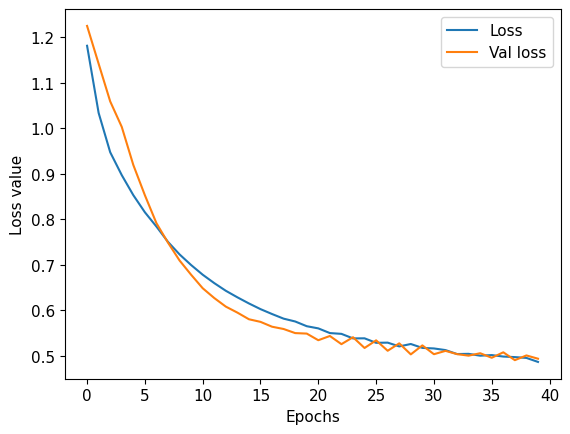

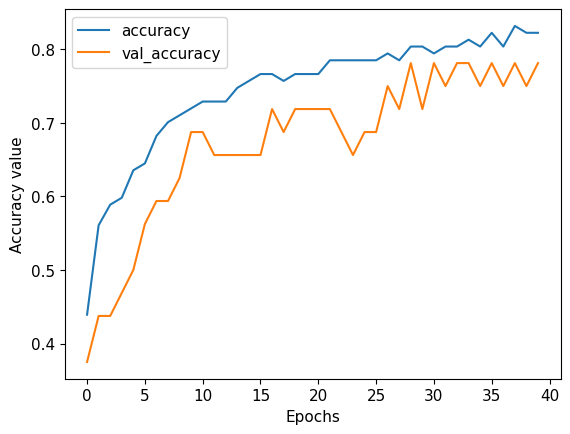

In [81]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy value')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
0.78125


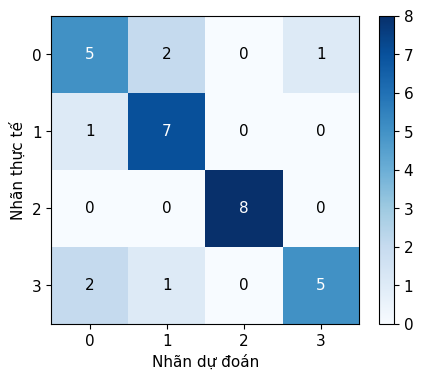

In [82]:
from mlxtend.plotting import plot_confusion_matrix
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_m = np.argmax(y_test, axis=1)
print(accuracy_score(y_test_m, y_pred))
# print(precision_score(y_test_m, y_pred))
# print(recall_score(y_test_m, y_pred))
# print(f1_score(y_test_m, y_pred))
cm = confusion_matrix(y_test_m, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm, colorbar=True, figsize=(5,4))
plt.rcParams.update({'font.size': 11})
plt.xlabel("Nhãn dự đoán")
plt.ylabel("Nhãn thực tế")
plt.show()

In [83]:
print(classification_report(y_test_m, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.62      0.62         8
           1       0.70      0.88      0.78         8
           2       1.00      1.00      1.00         8
           3       0.83      0.62      0.71         8

    accuracy                           0.78        32
   macro avg       0.79      0.78      0.78        32
weighted avg       0.79      0.78      0.78        32

